In [18]:
import torch
import torch.nn as nn

import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels, Tile_size):
        super(Generator, self).__init__()
        self.Tile_size = Tile_size
        self.img_channels = img_channels
        self.init_size = Tile_size // 4  # Downsample by a factor of 4
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256 * self.init_size * self.init_size),  # Output matches feature map size
            nn.BatchNorm1d(256 * self.init_size * self.init_size),
            nn.ReLU(),
        )

        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Upsample to (Tile_size // 2, Tile_size // 2)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, img_channels, kernel_size=4, stride=2, padding=1),  # Final upsample to (Tile_size, Tile_size)
            nn.Sigmoid(),  # Output scaled to [-1, 1]
        )

    def forward(self, z):
        out = self.model(z)
        out = out.view(out.size(0), 256, self.init_size, self.init_size)  # Reshape for ConvTranspose2d
        img = self.conv_layers(out)
        return img


In [13]:

class Discriminator(nn.Module):
    def __init__(self, img_channels, Tile_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1),  # Downsample
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Downsample
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Downsample
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear((Tile_size // 8) * (Tile_size // 8) * 256, 1),  # Final score
            nn.Sigmoid()  # Add Sigmoid activation here

        )

    def forward(self, img):
        return self.model(img)



In [31]:
from dataset import create_dataloader
from config.path import VERVET_DATA
# Hyperparameters
latent_dim = 100  # Size of the random noise vector
img_channels = 3  # Number of image channels
batch_size = 8
epochs = 30
Tile_size = 64

# Initialize models
generator = Generator(latent_dim, img_channels, Tile_size).to(device)
discriminator = Discriminator(img_channels, Tile_size).to(device)
# Optimizers
# Initialize optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Initialize schedulers
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=5, gamma=0.5)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=5, gamma=0.5)
# Loss function
adversarial_loss = nn.BCELoss()  # Binary Cross-Entropy Loss
dataloader = create_dataloader(brain="Vervet1818", map_type="FOM", patch_size=64, batch_size=8)


# Loss function
adversarial_loss = nn.BCELoss()


In [32]:
from torch.utils.data import DataLoader
import numpy as np
import torchvision
import matplotlib.pyplot as plt
"""
for epoch in range(epochs):
    for batch_idx, real_images in enumerate(dataloader):
        real_images = real_images.to(device)

        # Add Gaussian noise (out-of-place) to real images
        noisy_real_images = real_images + 0.05 * torch.randn_like(real_images)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Create smoothed real labels
        real_labels = torch.full((real_images.size(0), 1), 0.9, device=device)  # Real labels = 0.9
        fake_labels = torch.zeros((real_images.size(0), 1), device=device)      # Fake labels = 0.0

        # Generate fake images
        z = torch.randn(real_images.size(0), latent_dim).to(device)
        fake_images = generator(z)

        # Add Gaussian noise (out-of-place) to fake images
        noisy_fake_images = fake_images + 0.05 * torch.randn_like(fake_images)

        # Compute Discriminator Loss
        real_loss = adversarial_loss(discriminator(noisy_real_images), real_labels)
        fake_loss = adversarial_loss(discriminator(noisy_fake_images.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        gen_labels = torch.ones(real_images.size(0), 1).to(device)  # Generator tries to produce "real" images
        g_loss = adversarial_loss(discriminator(fake_images), gen_labels)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
"""


for epoch in range(epochs):
    for batch_idx, real_images in enumerate(dataloader):
        real_images = real_images.to(device)

        # Add Gaussian noise (out-of-place) to real images
        noisy_real_images = real_images + 0.05 * torch.randn_like(real_images)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Create smoothed real labels
        real_labels = torch.full((real_images.size(0), 1), 0.9, device=device)  # Real labels = 0.9
        fake_labels = torch.zeros((real_images.size(0), 1), device=device)      # Fake labels = 0.0

        # Generate fake images
        z = torch.randn(real_images.size(0), latent_dim).to(device)
        fake_images = generator(z)

        # Add Gaussian noise (out-of-place) to fake images
        noisy_fake_images = fake_images + 0.05 * torch.randn_like(fake_images)

        # Compute Discriminator Loss
        real_loss = adversarial_loss(discriminator(noisy_real_images), real_labels)
        fake_loss = adversarial_loss(discriminator(noisy_fake_images.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        gen_labels = torch.ones(real_images.size(0), 1).to(device)  # Generator tries to produce "real" images
        g_loss = adversarial_loss(discriminator(fake_images), gen_labels)
        g_loss.backward()
        optimizer_G.step()

    # Step the schedulers at the end of each epoch
    scheduler_G.step()
    scheduler_D.step()

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")




Epoch 1/30 | D Loss: 0.6083 | G Loss: 1.0671
Epoch 2/30 | D Loss: 0.5344 | G Loss: 1.0393
Epoch 3/30 | D Loss: 0.7918 | G Loss: 0.2007
Epoch 4/30 | D Loss: 0.6418 | G Loss: 1.8633
Epoch 5/30 | D Loss: 0.6556 | G Loss: 1.4274
Epoch 6/30 | D Loss: 0.4668 | G Loss: 1.0453
Epoch 7/30 | D Loss: 0.8497 | G Loss: 0.8183
Epoch 8/30 | D Loss: 0.4391 | G Loss: 1.8279
Epoch 9/30 | D Loss: 0.5258 | G Loss: 1.6799
Epoch 10/30 | D Loss: 0.5797 | G Loss: 0.9399
Epoch 11/30 | D Loss: 0.5932 | G Loss: 0.4260
Epoch 12/30 | D Loss: 0.4182 | G Loss: 1.4784
Epoch 13/30 | D Loss: 0.5845 | G Loss: 1.8798
Epoch 14/30 | D Loss: 0.8332 | G Loss: 0.5270
Epoch 15/30 | D Loss: 0.4627 | G Loss: 1.7204
Epoch 16/30 | D Loss: 0.5809 | G Loss: 0.8255
Epoch 17/30 | D Loss: 0.4130 | G Loss: 1.6353
Epoch 18/30 | D Loss: 1.0936 | G Loss: 0.6152
Epoch 19/30 | D Loss: 0.4834 | G Loss: 1.7985
Epoch 20/30 | D Loss: 0.4248 | G Loss: 1.3673
Epoch 21/30 | D Loss: 0.6177 | G Loss: 0.6775
Epoch 22/30 | D Loss: 0.4781 | G Loss: 0.97

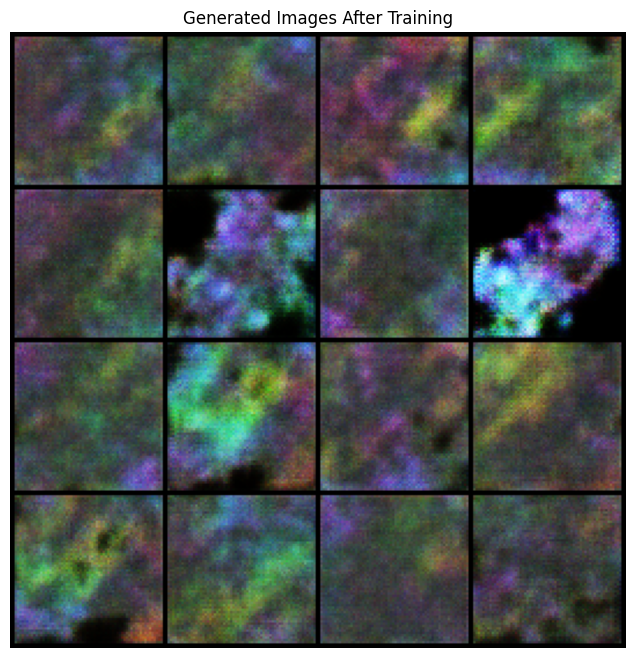

In [33]:
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    generated_images = generator(z)  # Already in [0, 1] range
    grid = torchvision.utils.make_grid(generated_images, nrow=4)

    # Plot the generated images
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title("Generated Images After Training")
    plt.show()


# Wasserstein GAN

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from dataset import create_dataloader
from config.path import VERVET_DATA
import random

# Hyperparameters
latent_dim = 100  # Size of the random noise vector
img_channels = 3  # Number of image channels
batch_size = 8
epochs = 30
Tile_size = 64
n_critic = 5  # Number of critic updates per generator update
clip_value = 0.01  # Weight clipping range

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels, Tile_size):
        super(Generator, self).__init__()
        self.Tile_size = Tile_size
        self.img_channels = img_channels
        self.init_size = Tile_size // 4  # Downsample by a factor of 4
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256 * self.init_size * self.init_size),  # Output matches feature map size
            nn.BatchNorm1d(256 * self.init_size * self.init_size),
            nn.ReLU(),
        )

        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Upsample to (Tile_size // 2, Tile_size // 2)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, img_channels, kernel_size=4, stride=2, padding=1),  # Final upsample to (Tile_size, Tile_size)
            nn.Sigmoid(),  # Scale output to [0, 1] for your data range
        )

    def forward(self, z):
        out = self.model(z)
        out = out.view(out.size(0), 256, self.init_size, self.init_size)  # Reshape for ConvTranspose2d
        img = self.conv_layers(out)
        return img

# Critic (Discriminator)
class Critic(nn.Module):
    def __init__(self, img_channels, Tile_size):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1),  # Downsample
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Downsample
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Downsample
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear((Tile_size // 8) * (Tile_size // 8) * 256, 1)  # Output unbounded score
        )

    def forward(self, img):
        return self.model(img)

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(latent_dim, img_channels, Tile_size).to(device)
critic = Critic(img_channels, Tile_size).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_C = optim.Adam(critic.parameters(), lr=0.0001, betas=(0.5, 0.999))

# DataLoader
dataloader = create_dataloader(brain="Vervet1818", map_type="FOM", patch_size=64, batch_size=8)

# Training Loop
for epoch in range(epochs):
    for batch_idx, real_images in enumerate(dataloader):
        real_images = real_images.to(device)

        # Add Gaussian noise to real images (out-of-place)
        noisy_real_images = real_images + 0.05 * torch.randn_like(real_images)

        # Train Critic
        optimizer_C.zero_grad()

        # Generate fake images
        z = torch.randn(real_images.size(0), latent_dim).to(device)
        fake_images = generator(z)

        # Add Gaussian noise to fake images (out-of-place)
        noisy_fake_images = fake_images + 0.05 * torch.randn_like(fake_images)

        # Compute Critic Loss
        real_loss = -torch.mean(critic(noisy_real_images))
        fake_loss = torch.mean(critic(noisy_fake_images.detach()))
        c_loss = real_loss + fake_loss
        c_loss.backward()
        optimizer_C.step()

        # Apply weight clipping to enforce Lipschitz constraint
        for p in critic.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Train Generator every n_critic steps
        if batch_idx % n_critic == 0:
            optimizer_G.zero_grad()
            g_loss = -torch.mean(critic(fake_images))
            g_loss.backward()
            optimizer_G.step()

    print(f"Epoch {epoch+1}/{epochs} | Critic Loss: {c_loss.item():.4f} | Generator Loss: {g_loss.item():.4f}")




Epoch 1/30 | Critic Loss: -0.4385 | Generator Loss: 0.2725
Epoch 2/30 | Critic Loss: -1.7336 | Generator Loss: 0.8367
Epoch 3/30 | Critic Loss: -0.2587 | Generator Loss: 0.8533
Epoch 4/30 | Critic Loss: -0.9663 | Generator Loss: 0.5444
Epoch 5/30 | Critic Loss: -1.0493 | Generator Loss: 0.6034
Epoch 6/30 | Critic Loss: -1.6390 | Generator Loss: 0.6319
Epoch 7/30 | Critic Loss: -1.0239 | Generator Loss: 0.8808
Epoch 8/30 | Critic Loss: -1.9235 | Generator Loss: 0.8833
Epoch 9/30 | Critic Loss: -1.6127 | Generator Loss: 0.7604
Epoch 10/30 | Critic Loss: -1.2032 | Generator Loss: 0.6817
Epoch 11/30 | Critic Loss: -1.6468 | Generator Loss: 0.7762
Epoch 12/30 | Critic Loss: -1.4509 | Generator Loss: 0.6449
Epoch 13/30 | Critic Loss: -1.6281 | Generator Loss: 0.6432
Epoch 14/30 | Critic Loss: -1.5516 | Generator Loss: 0.9898
Epoch 15/30 | Critic Loss: -1.6212 | Generator Loss: 0.7561
Epoch 16/30 | Critic Loss: -1.6999 | Generator Loss: 0.7622
Epoch 17/30 | Critic Loss: -1.7241 | Generator Lo

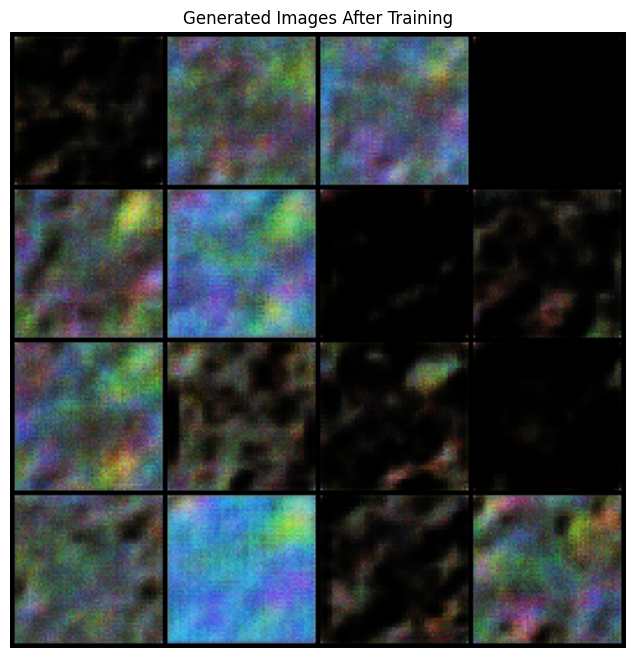

In [35]:
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    generated_images = generator(z)  # Already in [0, 1] range
    grid = torchvision.utils.make_grid(generated_images, nrow=4)

    # Plot the generated images
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title("Generated Images After Training")
    plt.show()